## Different LSTM Structures

We want to explore the different LSTM structures and evaluate the performance based on a simple, artificial dataset. The structures we are going to implement are:<br>
<br>
    - Vanilla LSTM: which is the standard LSTM we know already for comparison<br>
    - Bidirectional LSTM<br>
    - Stacked LSTM<br>
    - LSTM + CNN<br>

**0) Loading Libraries and Subroutines**

Standard libraries for plotting and numerical operations

In [65]:
import numpy as np
import matplotlib.pyplot as plt

Loading LSTM related keras libraries:

In [67]:
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

Calling a subroutine that puts the data set in the correct shape for LSTM (see later)

In [69]:
from prepare_data import prepare_data

<br>
As before, we generate a simple dataset, but this time with a higher noise level in order to challange the LSTMs we are going to build:

In [71]:
t_start = -50
t_end   = 20
incr    = 0.25

t       = np.arange(t_start, t_end, incr)
t       = t.reshape(len(t), 1)
Y_t     = np.sin(t) + 0.5*np.random.randn(len(t), 1) + np.exp((t + 20)*0.05)

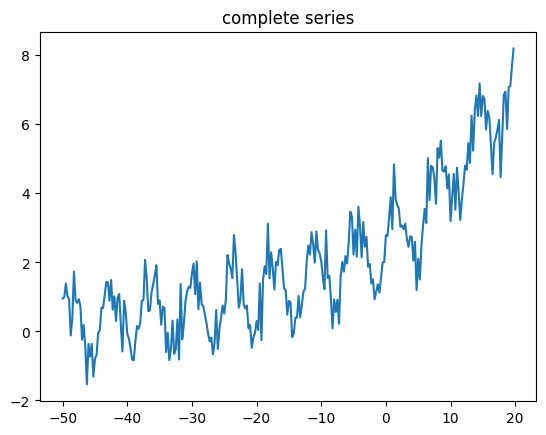

In [73]:
plt.plot(t, Y_t)
plt.title('complete series')
plt.show()

a) Scaling:

In [75]:
scaler  = MinMaxScaler(feature_range = (0, 1))
Y_tnorm = scaler.fit_transform(Y_t)

2b) Reshaping the Data

In [77]:
dt_past    = 20
dt_futu    = 8
n_features = 1

[X, Y] = prepare_data(Y_tnorm, dt_past, dt_futu)

2c) Splitting data into Training and Test dataset

In [79]:
cut            = int(np.round(0.7*Y_tnorm.shape[0]))

TrainX, TrainY = X[:cut], Y[:cut]
TestX,   TestY = X[cut:], Y[cut:]

In [81]:
print(TrainX.shape)
print(TrainY.shape)

(196, 20, 1)
(196, 8, 1)


In [83]:
print(Y_t.shape)

(280, 1)


<br>

**1) Vanilla LSTM**

As in the previous lecture, we start withe standard, aka *vanilla* LSTM<br>

1a) Generating the Model

In [85]:
n_neurons  = 100
batch_size = 128

model = Sequential()
model.add(LSTM(n_neurons, input_shape = (dt_past, n_features), activation = 'tanh'))
model.add(Dense(dt_futu))

opt = optimizers.Adam()
model.compile(loss = 'mean_squared_error', optimizer = opt)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 8)                 808       
                                                                 
Total params: 41608 (162.53 KB)
Trainable params: 41608 (162.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<br>

1b) Fitting the Model 

In [87]:
n_epochs = 100
out = model.fit(TrainX, TrainY, epochs = n_epochs, batch_size = batch_size, validation_split = 0.2, verbose = 2, shuffle = True)

Epoch 1/100
2/2 - 2s - loss: 0.0790 - val_loss: 0.1668 - 2s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 0.0650 - val_loss: 0.1347 - 103ms/epoch - 52ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0514 - val_loss: 0.1007 - 85ms/epoch - 42ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0369 - val_loss: 0.0629 - 98ms/epoch - 49ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0229 - val_loss: 0.0284 - 86ms/epoch - 43ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0155 - val_loss: 0.0184 - 85ms/epoch - 43ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0185 - val_loss: 0.0123 - 92ms/epoch - 46ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0130 - val_loss: 0.0168 - 87ms/epoch - 44ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0106 - val_loss: 0.0261 - 88ms/epoch - 44ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0121 - val_loss: 0.0307 - 83ms/epoch - 41ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0132 - val_loss: 0.0296 - 88ms/epoch - 44ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0127 - val_loss: 0.0242 - 80ms/epoch - 40ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0115 - v

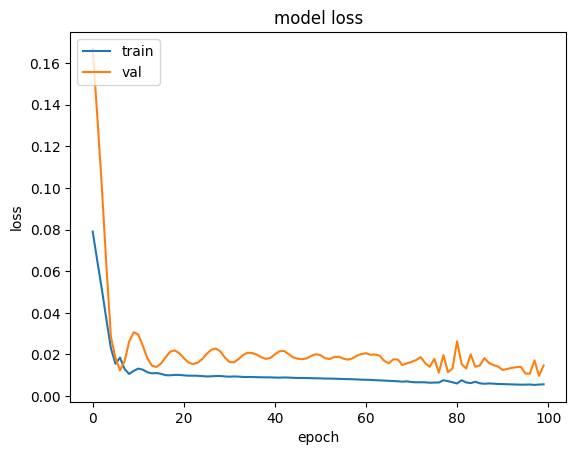

In [89]:
#plotting #############################################################
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('training loss.pdf')
plt.show()
#######################################################################

<br>

1c) Evaluating the Fit

2/2 [==============================] - 0s 9ms/step


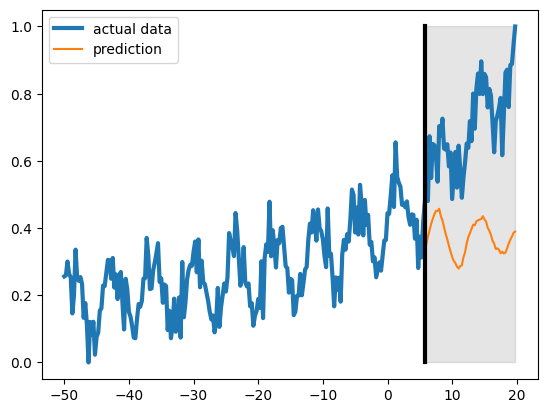

In [91]:
PredY = model.predict(TestX)
back  = PredY.shape[0]

plt.plot(t, Y_tnorm, linewidth = 3)
plt.plot(t[-back:], PredY[:, dt_futu-1])
plt.legend(['actual data', 'prediction'])
plt.fill_between([t[-back,0], t[-1,0]], 0, 1, color = 'k', alpha = 0.1)
plt.plot([t[-back,0], t[-back,0]], [0, 1], 'k-', linewidth = 3)
plt.show()

Let us run the same analysis, but with different LSTMs:

<br>

**2) Bidirectional LSTM**

For many sequences (like i.e. DNA, RNA, AA) it makes sense to read them from both directions and therefore makes it easier to detect pattern. For example a pattern in DNA sense (ATTCA) and antisense (ACTTA) direction might look mirrowed, hence diffferent, but they are actually the same feature with the same function.<br>
The only thing we need to do is call the corresponding library in *Keras*:<br>

In [93]:
from keras.layers import Bidirectional

...and add the class to our model: 

In [95]:
model = Sequential()
model.add(Bidirectional(LSTM(n_neurons, activation = 'tanh'), input_shape = (dt_past, n_features)))
model.add(Dense(dt_futu))

opt = optimizers.Adam()
model.compile(loss = 'mean_squared_error', optimizer = opt)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 200)               81600     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 8)                 1608      
                                                                 
Total params: 83208 (325.03 KB)
Trainable params: 83208 (325.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
out = model.fit(TrainX, TrainY, epochs = n_epochs, batch_size = batch_size, validation_split = 0.2, verbose = 2, shuffle = True)

Epoch 1/100
2/2 - 3s - loss: 0.0794 - val_loss: 0.1541 - 3s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.0600 - val_loss: 0.1136 - 148ms/epoch - 74ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0426 - val_loss: 0.0748 - 136ms/epoch - 68ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0272 - val_loss: 0.0379 - 124ms/epoch - 62ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0146 - val_loss: 0.0142 - 102ms/epoch - 51ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0131 - val_loss: 0.0126 - 112ms/epoch - 56ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0157 - val_loss: 0.0109 - 94ms/epoch - 47ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0115 - val_loss: 0.0160 - 113ms/epoch - 57ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0101 - val_loss: 0.0236 - 99ms/epoch - 49ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0110 - val_loss: 0.0282 - 99ms/epoch - 49ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0119 - val_loss: 0.0286 - 99ms/epoch - 50ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0116 - val_loss: 0.0253 - 93ms/epoch - 46ms/step
Epoch 13/100
2/2 - 0s - loss: 0.010

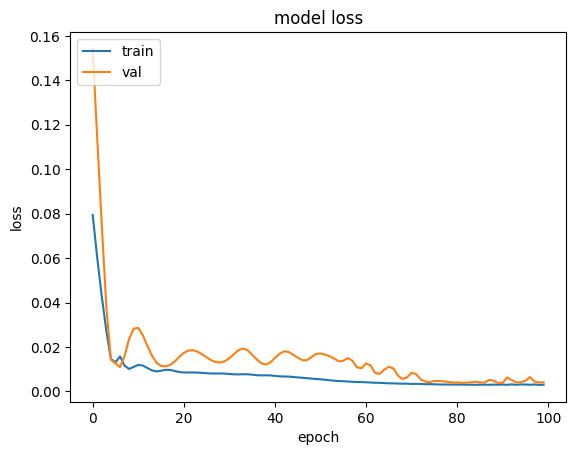

In [99]:
#plotting #############################################################
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('training loss.pdf')
plt.show()
#######################################################################

2/2 [==============================] - 2s 7ms/step


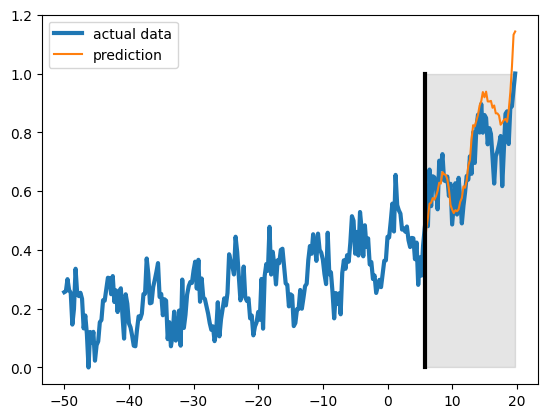

In [101]:
PredY = model.predict(TestX)
back  = PredY.shape[0]

plt.plot(t, Y_tnorm, linewidth = 3)
plt.plot(t[-back:], PredY[:, dt_futu-1])
plt.legend(['actual data', 'prediction'])
plt.fill_between([t[-back,0], t[-1,0]], 0, 1, color = 'k', alpha = 0.1)
plt.plot([t[-back,0], t[-back,0]], [0, 1], 'k-', linewidth = 3)
plt.show()

<br>

**3) Stacked LSTM**

In the same way we can run different convolution layer subsequently, we can add different LSTMs as stacks.<br>
For the **first LSTM**, we still need to provide the input shape. As an additional setting, we need to add *return_sequences = True* to **all LSTMs except the last one**, so that the output has the shape *(batch size i.e. sequence length x timesteps i.e. dt_past x hidden state)* in order to pass it on to the next LSTM layer (see matrix multiplication "MLP" lecture and "LSTM1" lecture).

In [103]:
model = Sequential()

model.add(LSTM(n_neurons,   activation = 'tanh', return_sequences = True, input_shape = (dt_past, n_features)))
model.add(LSTM(2*n_neurons, activation = 'relu', return_sequences = True))
model.add(LSTM(n_neurons,   activation = 'relu'))
model.add(Dense(dt_futu))

opt = optimizers.Adam()
model.compile(loss = 'mean_squared_error', optimizer = opt)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 20, 200)           240800    
                                                                 
 lstm_10 (LSTM)              (None, 100)               120400    
                                                                 
 dense_6 (Dense)             (None, 8)                 808       
                                                                 
Total params: 402808 (1.54 MB)
Trainable params: 402808 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
out = model.fit(TrainX, TrainY, epochs = n_epochs, batch_size = batch_size, validation_split = 0.2, verbose = 2, shuffle = True)

Epoch 1/100
2/2 - 4s - loss: 0.0765 - val_loss: 0.1759 - 4s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.0700 - val_loss: 0.1621 - 281ms/epoch - 141ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0631 - val_loss: 0.1397 - 263ms/epoch - 131ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0522 - val_loss: 0.0995 - 258ms/epoch - 129ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0341 - val_loss: 0.0386 - 255ms/epoch - 128ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0183 - val_loss: 0.0269 - 258ms/epoch - 129ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0206 - val_loss: 0.0211 - 249ms/epoch - 125ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0106 - val_loss: 0.0327 - 254ms/epoch - 127ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0121 - val_loss: 0.0363 - 277ms/epoch - 139ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0129 - val_loss: 0.0303 - 285ms/epoch - 143ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0119 - val_loss: 0.0218 - 410ms/epoch - 205ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0116 - val_loss: 0.0172 - 357ms/epoch - 178ms/step
Epoch 13/100
2/2 - 

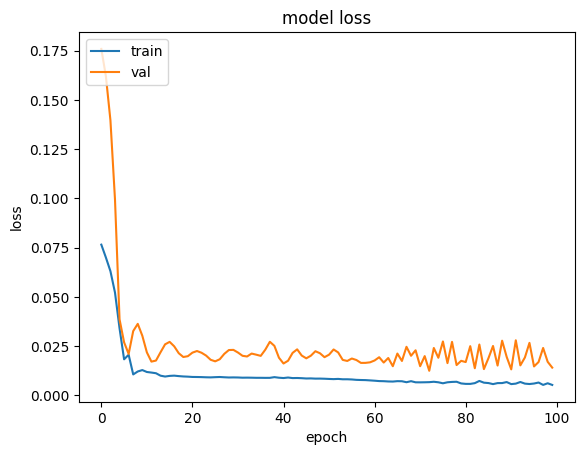

In [107]:
#plotting #############################################################
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('training loss.pdf')
plt.show()
#######################################################################

2/2 [==============================] - 1s 15ms/step


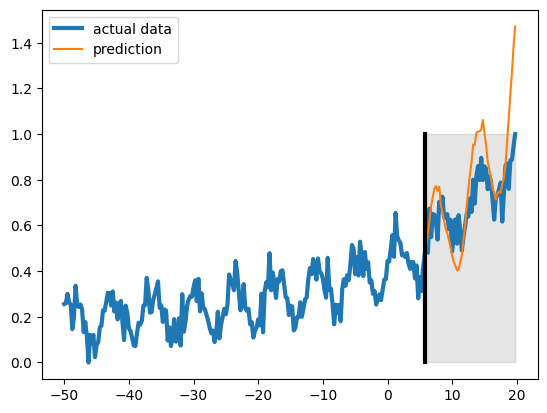

In [109]:
PredY = model.predict(TestX)
back  = PredY.shape[0]

plt.plot(t, Y_tnorm, linewidth = 3)
plt.plot(t[-back:], PredY[:, dt_futu-1])
plt.legend(['actual data', 'prediction'])
plt.fill_between([t[-back,0], t[-1,0]], 0, 1, color = 'k', alpha = 0.1)
plt.plot([t[-back,0], t[-back,0]], [0, 1], 'k-', linewidth = 3)
plt.show()

<br>

**4) LSTM + CNN**

Both, CNN and LSTM are quite sucessful on detecting pattern. A logical step is to combine both structures with their strenghts.

First, we need to call the corresponding libraries:

In [111]:
from keras.layers import Flatten, Conv1D, MaxPooling1D

But now there is a tricky part: The convolution layer expects the shape *(N_images, N_pixel_x, N_pixel_y, N_color_chan)*, but a sequence usually has the shape *(N_samples, N_timesteps, N_features)*. Thus, we first need to reshape the input matrix. But we also want to maintain the order of time. If we want to learn a pattern in time form a certain number of samples having a certain number of features, each time point needs to have the information from all features and all samples. Thus, the first coordinate is time (see the lecture slides for more details).<br> 
Thererfore, the shape for $X$ has to be *(N_timesteps, N_samples, dt_past, N_features)*.

In [113]:
N_samples  = 1

In [115]:
X          = X.reshape((X.shape[0], N_samples, dt_past, n_features))

In [117]:
TrainX, TrainY = X[:cut], Y[:cut]
TestX,   TestY = X[cut:], Y[cut:]

The next step is to make sure that the shapes from the convolution filters are passed on to the LSTM in the correct way. This is done by using the wrapper *TimeDistributed*. 

In [119]:
from keras.layers import TimeDistributed

Now, we are ready for building the model:

In [121]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 3, activation = 'relu'), input_shape = (None, dt_past, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(n_neurons, input_shape = (dt_past, n_features), activation = 'tanh'))
model.add(Dense(dt_futu))

opt = optimizers.Adam()
model.compile(loss = 'mean_squared_error', optimizer = opt)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, None, 18, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, None, 9, 64)       0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 576)         0         
 stributed)                                                      
                                                                 
 lstm_11 (LSTM)              (None, 100)               270800    
                                                                 
 dense_7 (Dense)             (None, 8)                 808       
                                                      

In [123]:
out = model.fit(TrainX, TrainY, epochs = n_epochs, batch_size = batch_size, validation_split = 0.2, verbose = 2, shuffle = False)

Epoch 1/100
2/2 - 3s - loss: 0.0713 - val_loss: 0.1509 - 3s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 0.0586 - val_loss: 0.1222 - 61ms/epoch - 31ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0464 - val_loss: 0.0931 - 67ms/epoch - 33ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0343 - val_loss: 0.0646 - 65ms/epoch - 32ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0233 - val_loss: 0.0394 - 75ms/epoch - 38ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0150 - val_loss: 0.0215 - 55ms/epoch - 27ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0113 - val_loss: 0.0139 - 79ms/epoch - 39ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0130 - val_loss: 0.0137 - 79ms/epoch - 39ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0165 - val_loss: 0.0137 - 62ms/epoch - 31ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0172 - val_loss: 0.0122 - 74ms/epoch - 37ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0150 - val_loss: 0.0115 - 75ms/epoch - 37ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0124 - val_loss: 0.0128 - 78ms/epoch - 39ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0107 - va

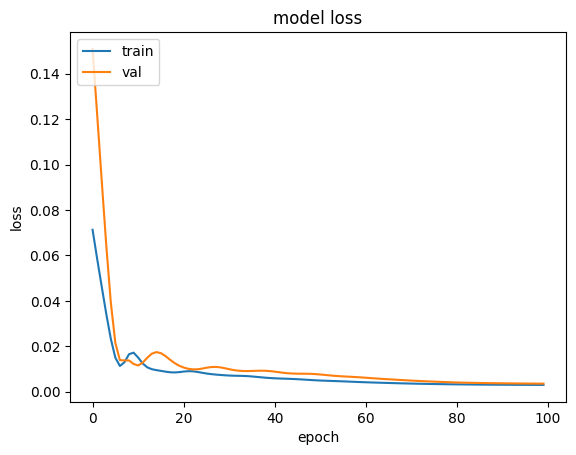

In [125]:
#plotting #############################################################
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('training loss.pdf')
plt.show()
#######################################################################

2/2 [==============================] - 1s 7ms/step


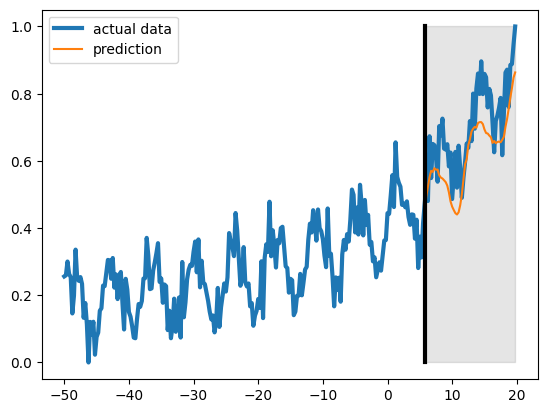

In [127]:
PredY = model.predict(TestX)
back  = PredY.shape[0]

plt.plot(t, Y_tnorm, linewidth = 3)
plt.plot(t[-back:], PredY[:, dt_futu-1])
plt.legend(['actual data', 'prediction'])
plt.fill_between([t[-back,0], t[-1,0]], 0, 1, color = 'k', alpha = 0.1)
plt.plot([t[-back,0], t[-back,0]], [0, 1], 'k-', linewidth = 3)
plt.show()

Compared to the other architectures, the result has improved alot!